In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
np.random.seed(42)

def create_sample_data(n_samples=5000):
    data = {
        'student_id': range(1, n_samples + 1),
        'age': np.random.randint(18, 65, n_samples),
        'gender': np.random.choice(['Male', 'Female', 'Other'], n_samples),
        'education_level': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
        'previous_courses': np.random.randint(0, 20, n_samples),
        'videos_watched': np.random.randint(0, 100, n_samples),
        'assignments_completed': np.random.randint(0, 15, n_samples),
        'forum_posts': np.random.randint(0, 50, n_samples),
        'quiz_scores_avg': np.random.uniform(0, 100, n_samples),
        'time_spent_hours': np.random.uniform(0, 200, n_samples),
        'login_frequency': np.random.randint(0, 100, n_samples),
        'days_active': np.random.randint(1, 90, n_samples),
        'certification_goal': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
    }
    
    df = pd.DataFrame(data)
    completion_score = (
        df['videos_watched'] * 0.3 +
        df['assignments_completed'] * 2 +
        df['quiz_scores_avg'] * 0.5 +
        df['time_spent_hours'] * 0.2 +
        df['days_active'] * 0.8 +
        df['certification_goal'] * 20 +
        np.random.normal(0, 10, n_samples)
    )
    
    df['completed'] = (completion_score > completion_score.median()).astype(int)
    
    return df

In [6]:
df = create_sample_data(5000)

df.to_csv('course_data.csv', index=False)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (5000, 14)

First few rows:
   student_id  age gender education_level  previous_courses  videos_watched  \
0           1   56   Male     High School                 7              53   
1           2   46   Male        Bachelor                14              15   
2           3   32   Male        Bachelor                14              80   
3           4   60  Other             PhD                18              90   
4           5   25  Other     High School                19               6   

   assignments_completed  forum_posts  quiz_scores_avg  time_spent_hours  \
0                     13           17        48.775371          4.477882   
1                      2           11        75.395749        154.632599   
2                      0           47        86.774106         15.955822   
3                     10           24        39.139003          3.410109   
4                     12           10         1.356957         29.483755   

   login_frequency  days_

In [7]:
print("\n Dataset Info")
print(df.info())

print("\n Statistical Summary")
print(df.describe())

print("\n Missing Values ")
print(df.isnull().sum())

print("\n Target Distribution ")
print(df['completed'].value_counts())
print(f"\nCompletion Rate: {df['completed'].mean()*100:.2f}%")



 Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   student_id             5000 non-null   int64  
 1   age                    5000 non-null   int32  
 2   gender                 5000 non-null   object 
 3   education_level        5000 non-null   object 
 4   previous_courses       5000 non-null   int32  
 5   videos_watched         5000 non-null   int32  
 6   assignments_completed  5000 non-null   int32  
 7   forum_posts            5000 non-null   int32  
 8   quiz_scores_avg        5000 non-null   float64
 9   time_spent_hours       5000 non-null   float64
 10  login_frequency        5000 non-null   int32  
 11  days_active            5000 non-null   int32  
 12  certification_goal     5000 non-null   int32  
 13  completed              5000 non-null   int32  
dtypes: float64(2), int32(9), int64(1), object

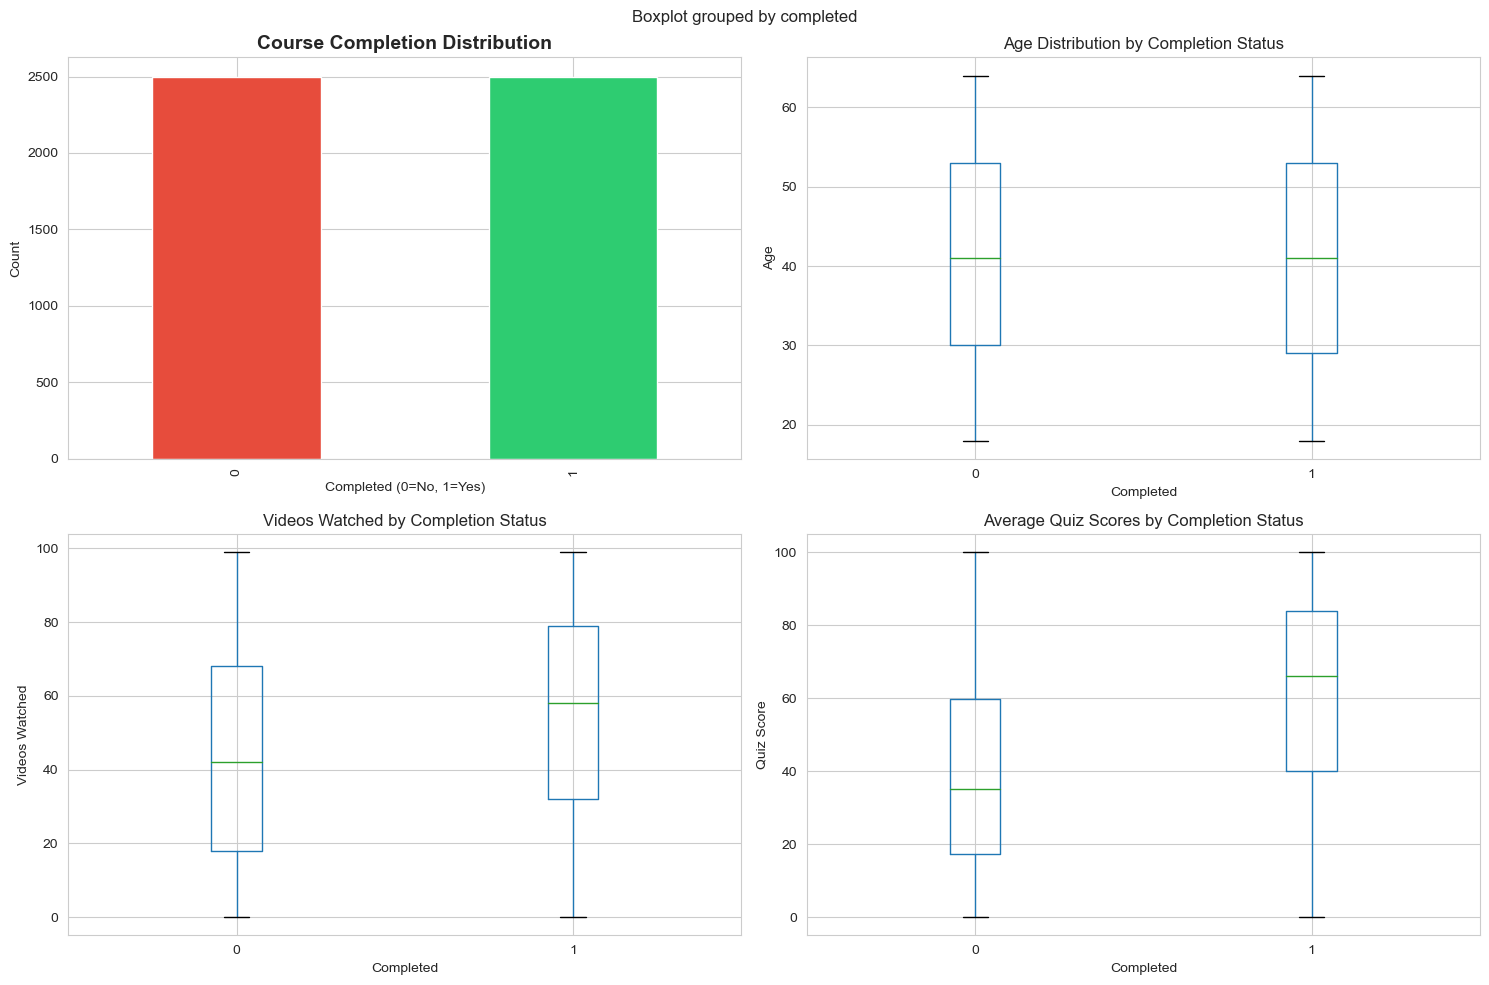

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

df['completed'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#e74c3c', '#2ecc71'])
axes[0,0].set_title('Course Completion Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Completed (0=No, 1=Yes)')
axes[0,0].set_ylabel('Count')

df.boxplot(column='age', by='completed', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Completion Status')
axes[0,1].set_xlabel('Completed')
axes[0,1].set_ylabel('Age')

df.boxplot(column='videos_watched', by='completed', ax=axes[1,0])
axes[1,0].set_title('Videos Watched by Completion Status')
axes[1,0].set_xlabel('Completed')
axes[1,0].set_ylabel('Videos Watched')

df.boxplot(column='quiz_scores_avg', by='completed', ax=axes[1,1])
axes[1,1].set_title('Average Quiz Scores by Completion Status')
axes[1,1].set_xlabel('Completed')
axes[1,1].set_ylabel('Quiz Score')

plt.tight_layout()
plt.show()

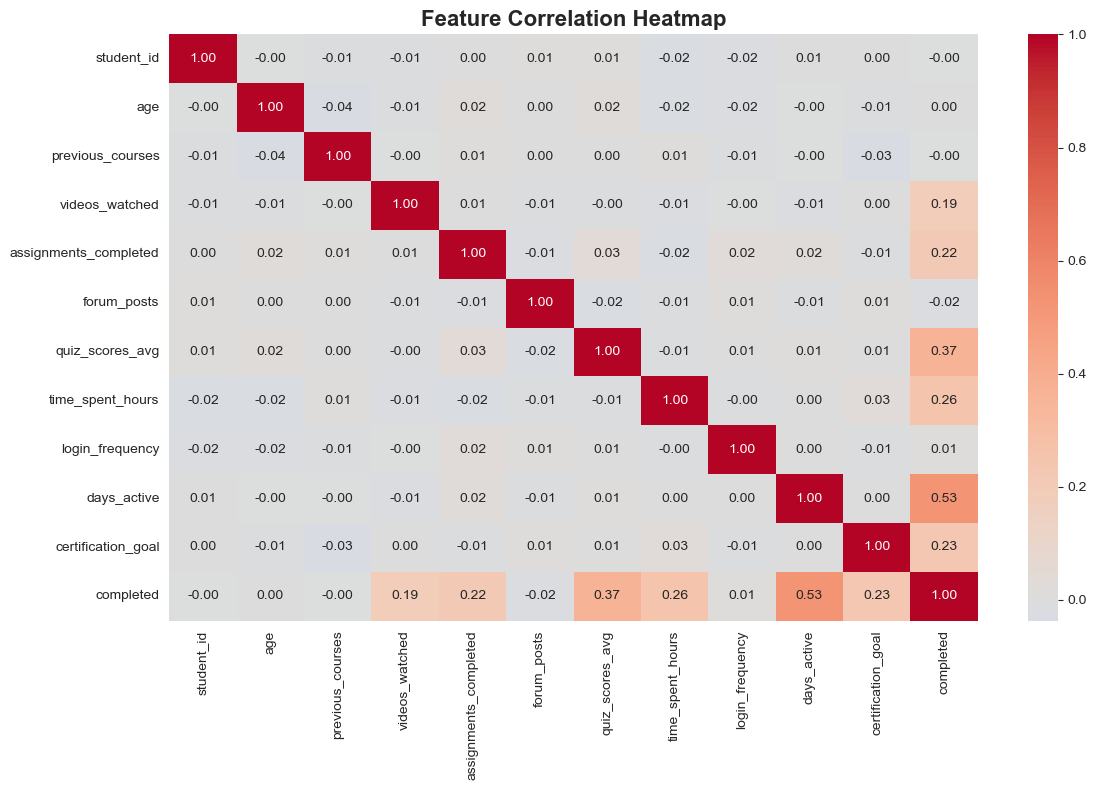

In [10]:
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
le_gender = LabelEncoder()
le_education = LabelEncoder()

df['gender_encoded'] = le_gender.fit_transform(df['gender'])
df['education_encoded'] = le_education.fit_transform(df['education_level'])

df['engagement_rate'] = df['videos_watched'] / (df['days_active'] + 1)
df['assignment_completion_rate'] = df['assignments_completed'] / 15
df['avg_time_per_day'] = df['time_spent_hours'] / (df['days_active'] + 1)
df['interaction_score'] = df['forum_posts'] + df['login_frequency']

In [12]:
feature_cols = [
    'age', 'gender_encoded', 'education_encoded', 'previous_courses',
    'videos_watched', 'assignments_completed', 'forum_posts',
    'quiz_scores_avg', 'time_spent_hours', 'login_frequency',
    'days_active', 'certification_goal', 'engagement_rate',
    'assignment_completion_rate', 'avg_time_per_day', 'interaction_score'
]

X = df[feature_cols]
y = df['completed']

print("\n Feature Importance Analysis ")
print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")


 Feature Importance Analysis 
Number of features: 16
Features: ['age', 'gender_encoded', 'education_encoded', 'previous_courses', 'videos_watched', 'assignments_completed', 'forum_posts', 'quiz_scores_avg', 'time_spent_hours', 'login_frequency', 'days_active', 'certification_goal', 'engagement_rate', 'assignment_completion_rate', 'avg_time_per_day', 'interaction_score']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (4000, 16)
Testing set size: (1000, 16)


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print('='*50)
    
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Training Logistic Regression...

Accuracy: 0.9020
ROC-AUC Score: 0.9733

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       500
           1       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000


Confusion Matrix:
[[446  54]
 [ 44 456]]

Training Random Forest...

Accuracy: 0.8740
ROC-AUC Score: 0.9580

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       500
           1       0.89      0.85      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Confusion Matrix:
[[448  52]
 [ 74 426]]

Training Gradient Boosting...

Accuracy: 0.8950
ROC-AUC Score: 0.9667

Cl

In [17]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\n=== Model Comparison ===")
print(comparison_df.sort_values('Accuracy', ascending=False))


=== Model Comparison ===
                 Model  Accuracy   ROC-AUC
0  Logistic Regression     0.902  0.973260
2    Gradient Boosting     0.895  0.966716
1        Random Forest     0.874  0.958048


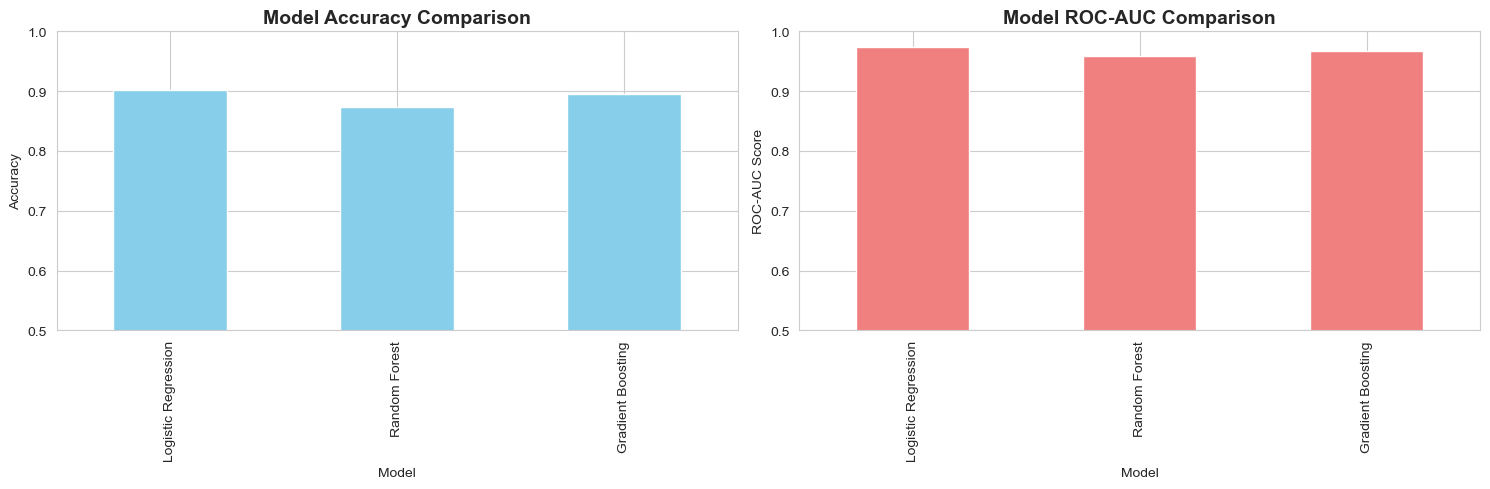

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

comparison_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], legend=False, color='skyblue')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0.5, 1.0])

comparison_df.plot(x='Model', y='ROC-AUC', kind='bar', ax=axes[1], legend=False, color='lightcoral')
axes[1].set_title('Model ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

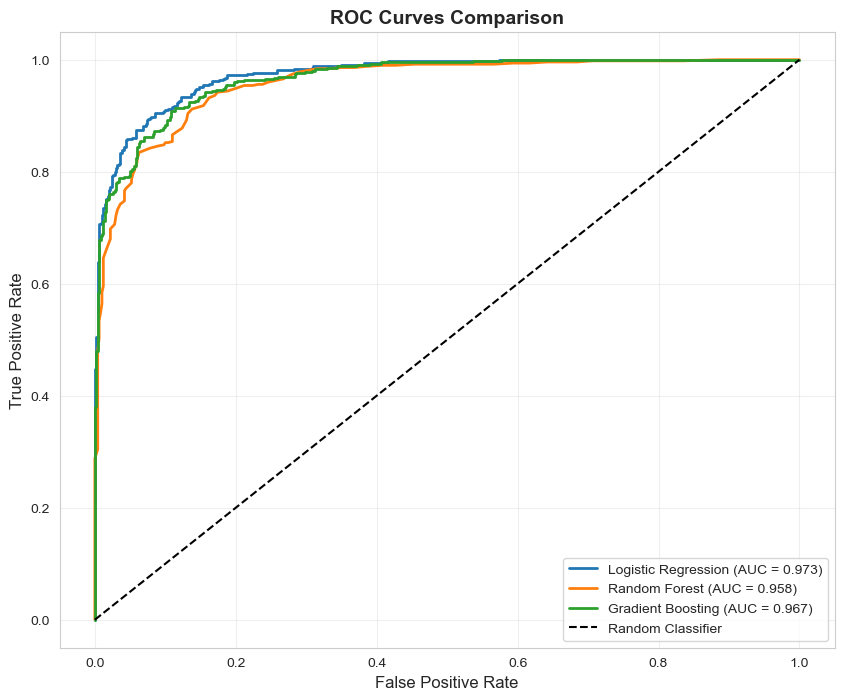

In [19]:
plt.figure(figsize=(10, 8))

for name in results.keys():
    if name == 'Logistic Regression':
        fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
    else:
        fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


=== Feature Importance (Random Forest) ===
                       feature  importance
10                 days_active    0.234708
7              quiz_scores_avg    0.175208
8             time_spent_hours    0.101752
12             engagement_rate    0.079551
14            avg_time_per_day    0.073951
4               videos_watched    0.071230
11          certification_goal    0.043356
5        assignments_completed    0.039750
13  assignment_completion_rate    0.036552
0                          age    0.026442
15           interaction_score    0.026047
9              login_frequency    0.025845
6                  forum_posts    0.025484
3             previous_courses    0.021313
2            education_encoded    0.010646
1               gender_encoded    0.008165


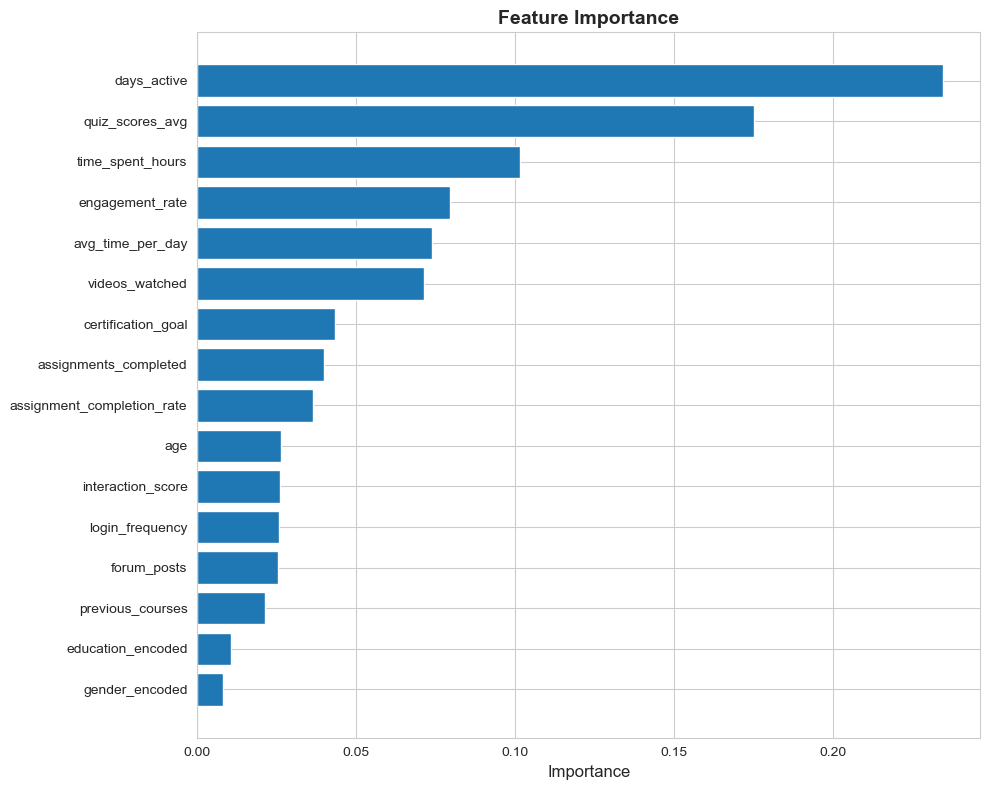

In [20]:
best_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importance (Random Forest) ===")
print(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:
best_model_name = 'Random Forest'
final_model = results[best_model_name]['model']

with open('course_completion_model.pkl', 'wb') as f:
    pickle.dump({
        'model': final_model,
        'scaler': scaler,
        'gender_encoder': le_gender,
        'education_encoder': le_education,
        'feature_cols': feature_cols
    }, f)

print(f"\n✓ Best Model ({best_model_name}) saved successfully!")
print(f"Final Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Final ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")


✓ Best Model (Random Forest) saved successfully!
Final Accuracy: 0.8740
Final ROC-AUC: 0.9580


In [22]:
def predict_completion(student_data):
   
    with open('course_completion_model.pkl', 'rb') as f:
        saved_data = pickle.load(f)
    
    model = saved_data['model']
    
   
    features = np.array([
        student_data['age'],
        student_data['gender_encoded'],
        student_data['education_encoded'],
        student_data['previous_courses'],
        student_data['videos_watched'],
        student_data['assignments_completed'],
        student_data['forum_posts'],
        student_data['quiz_scores_avg'],
        student_data['time_spent_hours'],
        student_data['login_frequency'],
        student_data['days_active'],
        student_data['certification_goal'],
        student_data['videos_watched'] / (student_data['days_active'] + 1),
        student_data['assignments_completed'] / 15,
        student_data['time_spent_hours'] / (student_data['days_active'] + 1),
        student_data['forum_posts'] + student_data['login_frequency']
    ]).reshape(1, -1)
    
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0]
    
    return prediction, probability


sample_student = {
    'age': 25,
    'gender_encoded': 0,
    'education_encoded': 1,
    'previous_courses': 3,
    'videos_watched': 75,
    'assignments_completed': 12,
    'forum_posts': 15,
    'quiz_scores_avg': 85.5,
    'time_spent_hours': 120,
    'login_frequency': 45,
    'days_active': 60,
    'certification_goal': 1
}

pred, proba = predict_completion(sample_student)
print(f"\n=== Sample Prediction ===")
print(f"Prediction: {'Will Complete' if pred == 1 else 'May Not Complete'}")
print(f"Probability: {proba[1]*100:.2f}% chance of completion")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE!")
print("="*50)


=== Sample Prediction ===
Prediction: Will Complete
Probability: 98.00% chance of completion

MODEL TRAINING COMPLETE!
